### Figure generation notebook for MERFISH single cell analysis

In [59]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import scvi
%matplotlib inline

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[8,7])
    plt.rc('svg', fonttype='none')

# To do: 

In [2]:
# Define the path of the analyzed data
dataPath = '../../../MERlin_Analysis/ProcessedResults/RawCounts/'

# Define the experiment
experimentName = 'Msliver_Cellboundary_PM1_12172020_FilteredSingleCellCounts.csv'

# Load the MERlin results
# Note that this assumes the data has already been filtered through the MERlin_quality_control notebook

# Counts per segmented cell
VizgenCounts = pd.read_csv(dataPath + experimentName)

# Load MACA data (10x)
dataPathMACA = '../../../../../../../data/angela/maca/tabula-muris-senis/0_data_ingest/01_figure_1'
experimentMACA = 'tabula-muris-senis-droplet-official-raw-obj.h5ad'

MACA_h5ad = anndata.read_h5ad(os.path.join(dataPathMACA, experimentMACA))\

# Select only the liver cells
MACAliver_h5ad = MACA_h5ad[MACA_h5ad.obs['tissue'] == 'Liver']

# Note: this file contains the raw counts data

# Get the gene expression matrix (this is clunky but I want more experience manipulating the data)
MACAliver = MACAliver_h5ad.to_df()

# Make a copy of MACA dataset with all genes
MACAliver_all = MACAliver.copy()

# Select PM1 gene panel genes only
MACAliver = MACAliver[list(VizgenCounts.columns)]

/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Panel A: UMAP of MERFISH

/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


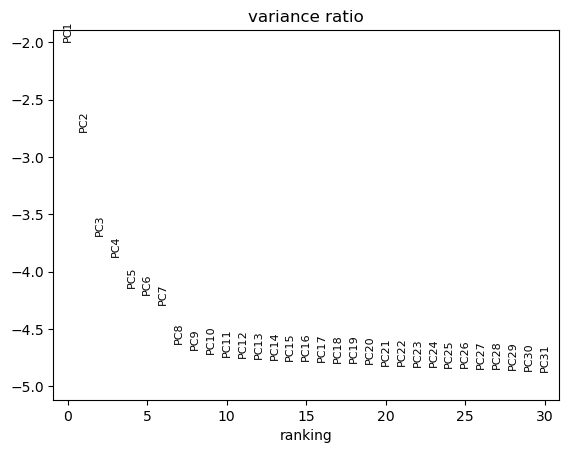

In [3]:
# Make a list of Anndata objects that filter out increasing numbers of cells.
N_counts_filter = 300
ad_Vizgen = anndata.AnnData(VizgenCounts)

# Preprocess the Anndata objects
scanpy.pp.filter_cells(ad_Vizgen, min_counts=N_counts_filter) #Filter based on total counts per cell
ad2_Vizgen_raw = ad_Vizgen.copy() #Save a copy of the raw counts
scanpy.pp.normalize_total(ad_Vizgen, target_sum=1e4) #Normalize the data to 10k counts
scanpy.pp.log1p(ad_Vizgen) #Logarithmize the data
scanpy.pp.scale(ad_Vizgen, max_value=10) #Scale each gene to unit variance and clip SD values over 10
scanpy.tl.pca(ad_Vizgen, svd_solver='arpack') #Compute PCA
    
# Plot the PCA variance ratios
scanpy.pl.pca_variance_ratio(ad_Vizgen, log=True)

In [4]:
# Calculate the individual UMAPs and do leiden clustering
scanpy.pp.neighbors(ad_Vizgen, n_neighbors=15, n_pcs=10) #Compute neighborhood graph (use n_neighbors = 12-15?)
scanpy.tl.umap(ad_Vizgen) #Compute UMAP embedding
scanpy.tl.leiden(ad_Vizgen, resolution=0.5)

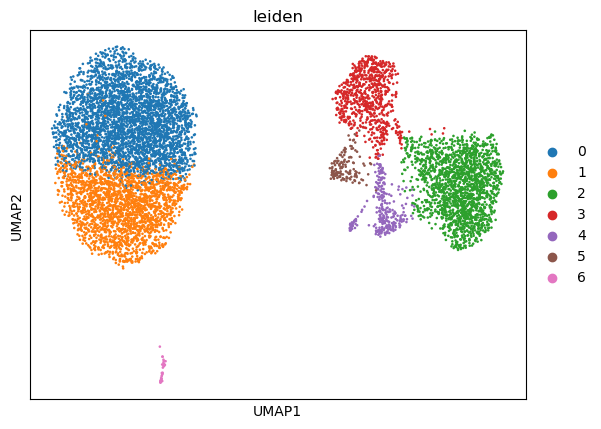

In [5]:
# Plot the UMAP clustering result
scanpy.pl.umap(ad_Vizgen, color='leiden') 

### Panel B: UMAP of MACA

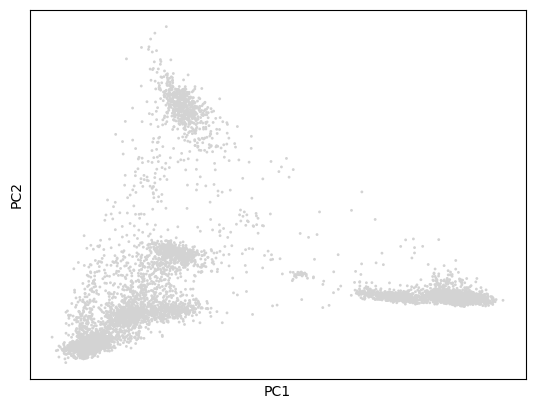

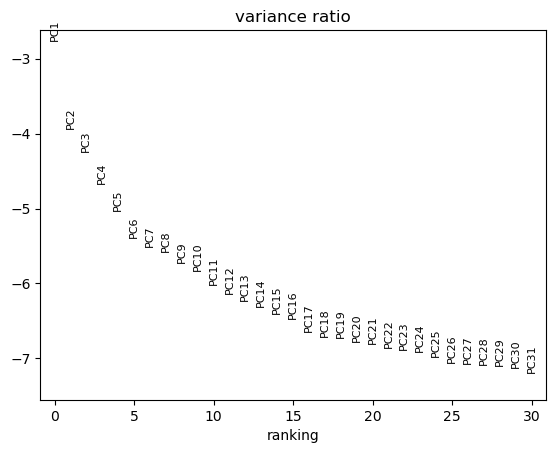

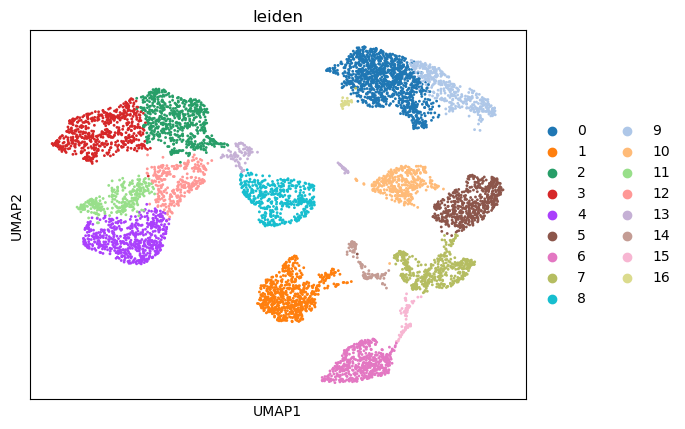

In [6]:
# Plot the UMAP for the full MACA transcriptome
ad2_MACA_all = anndata.AnnData(MACAliver_all)

scanpy.pp.filter_cells(ad2_MACA_all, min_counts=2000) #Filter based on total counts per cell
ad2_MACA_all_raw = ad2_MACA_all.copy() #Save a copy of the raw counts for scVI analysis later

scanpy.pp.normalize_total(ad2_MACA_all, target_sum=1e4) #Normalize the data
scanpy.pp.log1p(ad2_MACA_all) #Logarithmize the data
scanpy.pp.scale(ad2_MACA_all, max_value=10) #Scale each gene to unit variance and clip SD values over 10
scanpy.tl.pca(ad2_MACA_all, svd_solver='arpack') #Compute PCA
scanpy.pl.pca(ad2_MACA_all) #Plot PCs
scanpy.pl.pca_variance_ratio(ad2_MACA_all, log=True) #Plot PCA variance ratios
scanpy.pp.neighbors(ad2_MACA_all, n_neighbors=15, n_pcs=10) #Compute neighborhood graph
scanpy.tl.umap(ad2_MACA_all) #Compute UMAP embedding
scanpy.tl.leiden(ad2_MACA_all, resolution=0.5) #Cluster with leiden algorithm
scanpy.pl.umap(ad2_MACA_all, color='leiden') #Plot UMAP

### Panel C and D: scVI combination of MERFISH and MACA

In [7]:
# Third, try scVI
ad2_combined_all_scVI = ad2_Vizgen_raw.concatenate(ad2_MACA_all_raw, batch_categories=['Vizgen','MACA'])
scvi.data.setup_anndata(ad2_combined_all_scVI, batch_key = 'batch') #Load the data into scVI
model = scvi.model.SCVI(ad2_combined_all_scVI) #Setup the model
model.train() #Train the model

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 15897 cells, 128 vars, 2 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [07:26<00:00,  1.12s/it]
INFO     Training time:  446 s. / 400 epochs                                                 


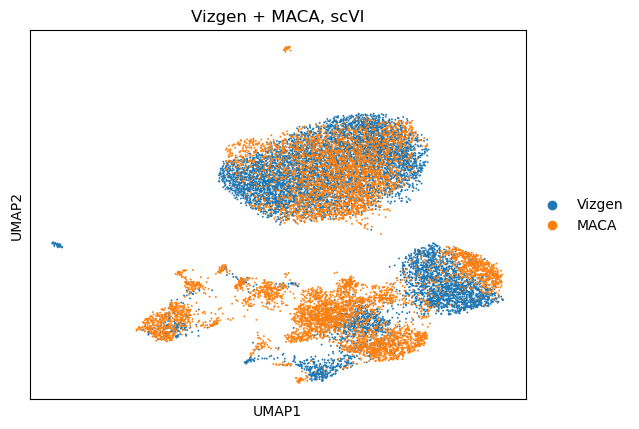

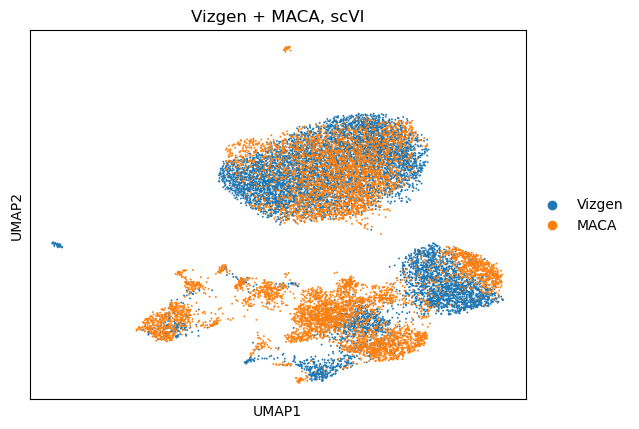

In [10]:
# Save the results from scVI
latent = model.get_latent_representation()
ad2_combined_all_scVI.obsm["X_scVI"] = latent
ad2_combined_all_scVI.layers["scVI_normalized"] = model.get_normalized_expression(library_size=10e4)

# Generate UMAP in scVI latent space
scanpy.pp.neighbors(ad2_combined_all_scVI, use_rep="X_scVI")
scanpy.tl.umap(ad2_combined_all_scVI)
scanpy.pl.umap(ad2_combined_all_scVI, color='batch', title='Vizgen + MACA, scVI')

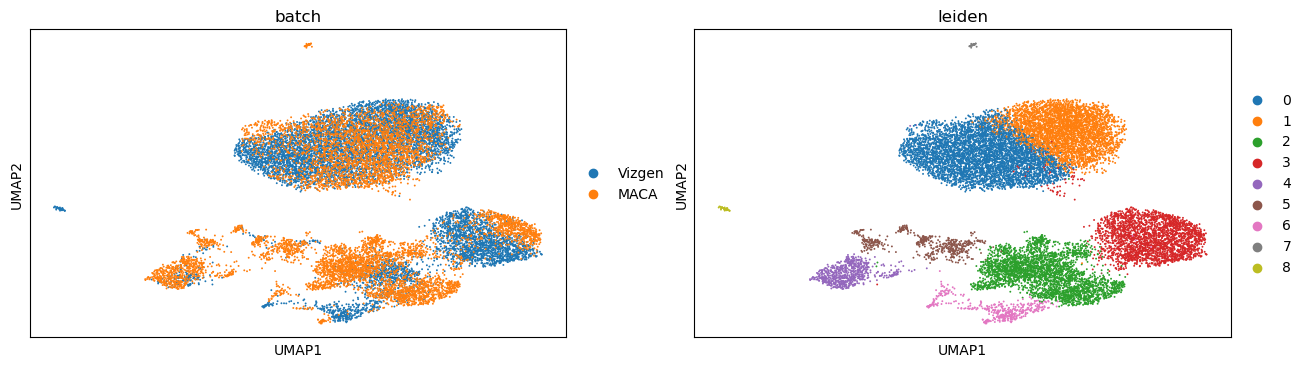

In [11]:
# Cluster off of scVI
scanpy.tl.leiden(ad2_combined_all_scVI, resolution=0.5)

# Plot the batch + leiden results
with plt.rc_context({'figure.figsize': (7,4)}):
    scanpy.pl.umap(ad2_combined_all_scVI, color=['batch','leiden'], ncols=2, vmax='p99')

### Plot combined figure

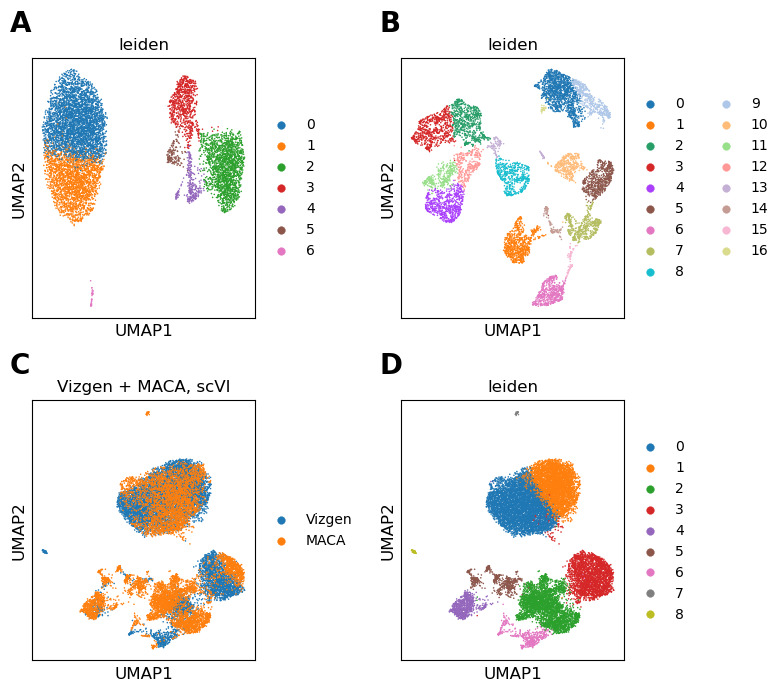

In [64]:
# Plot the whole figure
set_plotting_style()
fig, ax = plt.subplots(2,2)

# Panel A
ax[0,0] = scanpy.pl.umap(ad_Vizgen, color='leiden', ax=ax[0,0], size=5, title='leiden', show=False)

# Panel B
ax[0,1] = scanpy.pl.umap(ad2_MACA_all, color='leiden', ax=ax[0,1], size=5, title='leiden', show=False)

# Panel C
ax[1,0] = scanpy.pl.umap(ad2_combined_all_scVI, color='batch', size=5, 
                         title='Vizgen + MACA, scVI', ax=ax[1,0], show=False)

# Panel D
ax[1,1] = scanpy.pl.umap(ad2_combined_all_scVI, color='leiden', size=5, 
                         title='leiden', ax=ax[1,1], show=False)

# Label subpanels
axes = ax.flat
for n, ax in enumerate(axes):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')


fig.tight_layout()
fig

In [65]:
# Export figures
fig.savefig('../../figures/Fig5_singlecellanalysis.pdf')
fig.savefig('../../figures/Fig5_singlecellanalysis.png')